<a href="https://colab.research.google.com/github/hunble/IAC-Model-PDPTool-/blob/main/PDPTool.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# set parameters
max = 1
min = -0.2
rest = -0.1
decay = 0.1
estr = 0.4 
alpha = 0.2 # see note (below)
gamma = 0.1
 
# note: we increased alpha from the parameter value in pdp handbook (where alpha = 0.1) . The reason is that without this excitation scaling parameter increase, intrapool competition squashes activations of all units without external input, and so we fail to see interactivity reflected in final activations of units in the input pools... 
 
# set number of cycles
ncycles = 100
 
 
 
print(min)

-0.2


In [ ]:
import numpy as np

class Pool:
  def __init__(self, n, name, type, nunits, unit_names, projections, weights, extInput = None):
    if extInput is None:
      extInput = np.zeros(nunits)

    self.pool_number = n
    self.name = name
    self.type = type
    self.nunits = nunits
    self.unit_names = unit_names
    self.projections = projections
    self.weights = weights
    self.extInput = extInput
    self.activation = np.zeros(nunits)
    self.inhibition = np.zeros(nunits)
    self.excitation = np.zeros(nunits)
    self.netInput = np.zeros(nunits)
    self.activation_history = []


In [ ]:
import pandas as pd
f2F = pd.read_csv("drive/MyDrive/jets/f2f.csv")
f2F.rename( columns={'Unnamed: 0':'name'}, inplace=True )
# s = f2F.to_numpy()
# row.names(f2F) <- f2F[,1]
# f2F <- f2F %>% select(-X)
# f2F <- as.matrix(f2F)
f2F = f2F.drop('name', 1)
f2F = f2F.to_numpy()

In [ ]:
f2H = pd.read_csv("drive/MyDrive/jets/f2h.csv") 
# f2H$Divorced[f2H$Divorced == "1`"] <- "1"
# f2H$Divorced <- as.numeric(f2H$Divorced)
# f2H$Divorced[f2H$Divorced == 1] <- 0
# f2H$Divorced[f2H$Divorced == 2] <- 1
# f2H[is.na(f2H)] <- 0
# row.names(f2H)<- f2H[,1]
# # convert to matrix
# f2H <- f2H %>% select(-X) %>% as.matrix()
f2H.rename( columns={'Unnamed: 0':'name'}, inplace=True )
f2H.set_index("name")
f2H = f2H.fillna(0)
f2H['Divorced'].loc[(f2H['Divorced'] == "1`")] = 1
f2H = f2H.drop('name', 1)
f2H = f2H.to_numpy()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
# names to names [27 x 27]
# [1] Art	Al	Sam	Clyde	Mike	Jim	Greg	John	Doug	Lance	George	Pete	
# [13] Fred	Gene	Ralph	Phil	Ike	Nick	Don	Ned	Karl	Ken	Earl	Rick	Ol	Neal	Dave
n2N = np.zeros((27, 27))
n2N.fill(-1)
np.fill_diagonal(n2N, 0)


In [ ]:
# names to hidden [27 x 27]
# [1] Art	Al	Sam	Clyde	Mike	Jim	Greg	John	Doug	Lance	George	Pete	
# [13] Fred	Gene	Ralph	Phil	Ike	Nick	Don	Ned	Karl	Ken	Earl	Rick	Ol	Neal	Dave
n2H = np.zeros((27, 27))
np.fill_diagonal(n2H, 1)


In [ ]:
# hidden to hidden [27 x 27]
# [1] Art	Al	Sam	Clyde	Mike	Jim	Greg	John	Doug	Lance	George	Pete	
# [13] Fred	Gene	Ralph	Phil	Ike	Nick	Don	Ned	Karl	Ken	Earl	Rick	Ol	Neal	Dave
h2H = n2N # same as n2N

In [ ]:
featurePool = Pool(1, "features", "input", 14, 
                 unit_names = ["Jets", "Sharks","20s",	"30s"	,"40s", "JH", "HS", "COL",
                                "Single", "Married", "Divorced", "Bookie", "Burglar", "Pusher"],
                 projections = [1, 3], 
                 weights = {'1':f2F, '3':f2H}  , extInput=[0,0,1,0,0,1,0,0,0,0,0,0,0,0]
                 )


namePool = Pool(2, "names", "input", 27, 
                 unit_names = ['Art',	'Al',	'Sam',	'Clyde',	'Mike',	'Jim',	'Greg',	'John',	'Doug',	
                                'Lance',	'George',	'Pete',	'Fred',	'Gene',	'Ralph',	'Phil',	'Ike',	
                                'Nick',	'Don',	'Ned',	'Karl',	'Ken',	'Earl',	'Rick',	'Ol',	'Neal',	
                                'Dave'],
                 projections = [2, 3], 
                 weights = {'2':n2N, '3':n2H}
)

hiddenPool = Pool(3, "hidden", "hidden", 27, 
                 unit_names = ['Art',	'Al',	'Sam',	'Clyde',	'Mike',	'Jim',	'Greg',	'John',	'Doug',	
                                'Lance',	'George',	'Pete',	'Fred',	'Gene',	'Ralph',	'Phil',	'Ike',	
                                'Nick',	'Don',	'Ned',	'Karl',	'Ken',	'Earl',	'Rick',	'Ol',	'Neal',	
                                'Dave'],
                 projections = [1, 2, 3], 
                 weights = {'1':f2H.transpose(), '2':n2H.transpose(), '3':h2H.transpose()}
                  )
import copy

def run_simulation(pool_, ncycles):
  # pool_: list of pools in network
  # ncycles: number of cycles in simulation 
  pool_[0].activation_history = []
  pool_[1].activation_history = []
  pool_[2].activation_history = []
  for x in range(0,ncycles):
    print("------------------------Cycle Number: ", x)
    # get net
    for (i,_) in enumerate(pool_):

      pool_[i].excitation = np.zeros(pool_[i].nunits)
      pool_[i].inhibition = np.zeros(pool_[i].nunits)

      for sender in pool_[i].projections:
        positive_acts_indices = np.where(pool_[sender-1].activation > 0)[0]
        # print("indices", positive_acts_indices)
        if positive_acts_indices.size > 0:
          for k in range(0,positive_acts_indices.size):
            index = positive_acts_indices[k]
            # print(sender, i) 
            # print(pool_[i].weights[str(sender)])
            wts = pool_[i].weights[str(sender)][index,] ### 

            # print("wts", wts)
            # print("hunble", pool.inhibition[wts < 0])
            # print("hunble", pool_[sender-1].activation[i])
            pool_[i].excitation[wts > 0] = pool_[i].excitation[wts > 0] + pool_[sender-1].activation[index] * wts[wts > 0]
            pool_[i].inhibition[wts < 0] = pool_[i].inhibition[wts < 0] + pool_[sender-1].activation[index] * wts[wts < 0]
            # print("Excitation: ",pool.excitation)
            # print("Inhibition: ",pool.inhibition)
          # end for
        # end conditional
        pool_[i].excitation = pool_[i].excitation * alpha
        pool_[i].inhibition = pool_[i].inhibition * gamma
        pool_[i].netInput = pool_[i].excitation + pool_[i].inhibition + [element * estr for element in pool_[i].extInput]
        # print("Net Input: ", pool.netInput)

    # update
    for (index,_) in enumerate(pool_):
      pns = np.where(pool_[index].netInput > 0)[0]
      # print("netInput: ", p.netInput)
      # print("Activation: ", p.activation)
      # print("pns:", pns)
      if (len(pns) > 0):
        pool_[index].activation[pns] = pool_[index].activation[pns] + (max - pool_[index].activation[pns])*pool_[index].netInput[pns] - decay*(pool_[index].activation[pns] - rest) ### 
      # end if
      nps = np.where(pool_[index].netInput <= 0) 
      if (len(nps) >0):
        pool_[index].activation[nps] = pool_[index].activation[nps] + (pool_[index].activation[nps] - min)*pool_[index].netInput[nps] - decay*(pool_[index].activation[nps] - rest)
      # end if
      
      pool_[index].activation[pool_[index].activation > max] = max
      pool_[index].activation[pool_[index].activation < min] = min
      
      #save activation to history
      # p.activation_history[x] = p.activation
      # print("before append:",pool_[index].activation_history)
      jumper = copy.copy(pool_[index].activation)
      pool_[index].activation_history.append(jumper)
      # print("activation")
      # print(pool_[index].activation_history[len(pool_[index].activation_history)-1:])
      # print(pool_[index].activation_history)

    # end for

    # end 100 cycles
  # print("Pool,", pool_[0].activation_history)
  return pool_
  

result = run_simulation([featurePool,namePool,hiddenPool], ncycles=ncycles)

------------------------Cycle Number:  0
------------------------Cycle Number:  1
------------------------Cycle Number:  2
------------------------Cycle Number:  3
------------------------Cycle Number:  4
------------------------Cycle Number:  5
------------------------Cycle Number:  6
------------------------Cycle Number:  7
------------------------Cycle Number:  8
------------------------Cycle Number:  9
------------------------Cycle Number:  10
------------------------Cycle Number:  11
------------------------Cycle Number:  12
------------------------Cycle Number:  13
------------------------Cycle Number:  14
------------------------Cycle Number:  15
------------------------Cycle Number:  16
------------------------Cycle Number:  17
------------------------Cycle Number:  18
------------------------Cycle Number:  19
------------------------Cycle Number:  20
------------------------Cycle Number:  21
------------------------Cycle Number:  22
------------------------Cycle Number:  23
--

In [ ]:
result[0].activation_history

[array([-0.01, -0.01,  0.39, -0.01, -0.01,  0.39, -0.01, -0.01, -0.01,
        -0.01, -0.01, -0.01, -0.01, -0.01]),
 array([-0.019   , -0.019   ,  0.585   , -0.019741, -0.019741,  0.585   ,
        -0.019741, -0.019741, -0.019   , -0.019   , -0.019   , -0.019   ,
        -0.019   , -0.019   ]),
 array([-0.0271    , -0.0271    ,  0.6825    , -0.02882142, -0.02882142,
         0.6825    , -0.02882142, -0.02882142, -0.0271    , -0.0271    ,
        -0.0271    , -0.0271    , -0.0271    , -0.0271    ]),
 array([-0.03439   , -0.03439   ,  0.73125   , -0.03710757, -0.03710757,
         0.73125   , -0.03710757, -0.03710757, -0.03439   , -0.03439   ,
        -0.03439   , -0.03439   , -0.03439   , -0.03439   ]),
 array([-0.040951  , -0.040951  ,  0.755625  , -0.04458796, -0.04458796,
         0.755625  , -0.04458796, -0.04458796, -0.040951  , -0.040951  ,
        -0.040951  , -0.040951  , -0.040951  , -0.040951  ]),
 array([-0.0468559, -0.0468559,  0.7678125, -0.0513035, -0.0513035,
         0.7

In [ ]:
# rank final activations by pool 
def rank_activations_by_pool(pool_):


  f_df = pd.DataFrame(data={'feature': pool_[0].unit_names, 
                    'activation':  pool_[0].activation})

  n_df = pd.DataFrame(data={'feature': pool_[1].unit_names, 
                    'activation':  pool_[1].activation})

  h_df = pd.DataFrame(data={'feature': pool_[2].unit_names, 
                    'activation':  pool_[2].activation})

 

  f_df = f_df.sort_values(by=['activation'], ascending=False)
  n_df = n_df.sort_values(by=['activation'], ascending=False)
  h_df = h_df.sort_values(by=['activation'], ascending=False)


  return [('features', f_df), ('names', n_df), ('hidden', h_df)]



print(rank_activations_by_pool(result)[0])

('features',      feature  activation
2        20s    0.782134
5         JH    0.782134
0       Jets   -0.048643
12   Burglar   -0.048643
9    Married   -0.073707
10  Divorced   -0.073707
1     Sharks   -0.099997
8     Single   -0.099997
11    Bookie   -0.099997
13    Pusher   -0.099997
3        30s   -0.107253
4        40s   -0.107253
6         HS   -0.107253
7        COL   -0.107253)


In [ ]:
def plot_pools(pool_):
  f_df = pd.DataFrame(result[0].activation_history, columns = result[0].unit_names)
  n_df = pd.DataFrame(result[1].activation_history, columns = result[1].unit_names)
  h_df = pd.DataFrame(result[2].activation_history, columns = result[2].unit_names)

  f_df.plot()

  n_df.plot()

  h_df.plot()

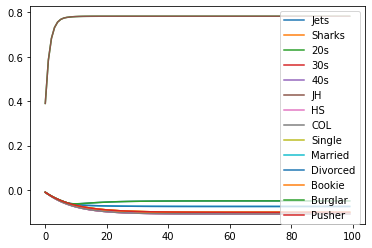

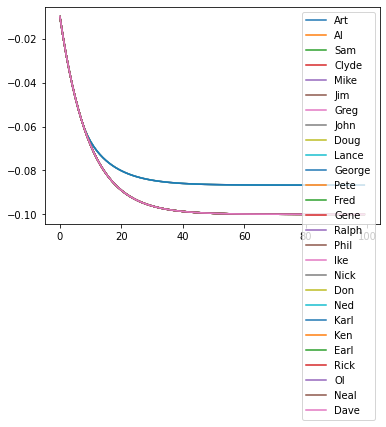

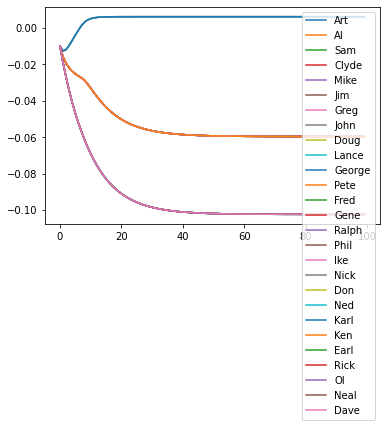

In [ ]:
plot_pools(result)

In [ ]:
import pandas as pd

# plot activations per pool over time
def plot_pools(pool_):

  # pool 1 features
  a_history_1 = pool_[1].activation_history
  unit_names_1 = pool_[1].unit_names
  m1 = do.call(rbind, a_history_1)
  colnames(m1) = unit_names_1
  plot1 = ggplot(melt(m1), aes(x=Var1, y=value, col=Var2)) + 
    labs(x = "Cycle", y = "Activation", color = "Feature", title = "Activation of Feature Units by Cycle") +
    geom_line() 

  # pool 2 names
  a_history_2 = pool_[2].activation_history
  unit_names_2 = pool_[2].unit_names

  m1 = do.call(rbind, a_history_2)
  colnames(m1) = unit_names_2
  plot2 = ggplot(melt(m1), aes(x=Var1, y=value, col=Var2)) + 
    labs(x = "Cycle", y = "Activation", color = "Name", title = "Activation of Name Units by Cycle") +
    geom_line() 

  # pool 3 - hidden 
  a_history = pool_[3].activation_history
  unit_names = pool_[3].unit_names

  m1 = do.call(rbind, a_history)
  colnames(m1) = unit_names
  plot3 = ggplot(melt(m1), aes(x=Var1, y=value, col=Var2)) + 
    labs(x = "Cycle", y = "Activation", color = "Hidden Unit", title = "Activation of Hidden Units by Cycle") + 
    geom_line() 

  return(list("features" = plot1, "names" = plot2, "hidden" = plot3))
  

SyntaxError: ignored

In [ ]:
plot_pools(result)

NameError: ignored

In [ ]:

import pandas as pd
import numpy as np
data = pd.read_csv("IAC.csv")



def make_f2H(data):

  features = np.array([])

  buckets = []

  for col in data:
      # print(data[col].unique())
      d = data[col].unique()
      features = np.append(features,data[col].unique())
      buckets.append(d)


  f2H = np.zeros([len(data), len(features)])

  # print(len(buckets))


  indexAdjust = 0
  for index, row in data.iterrows():
    indexAdjust = 0
    for j in range(len(buckets)):
      # print(buckets[j])
      for k in range(len(buckets[j])):
        if buckets[j][k] == row[j]:
          # print(buckets[j][k], row[j])
          # print(index,k+ indexAdjust)
          
          f2H[index][k + indexAdjust] = 1
      indexAdjust += len(buckets[j])




  return f2H



def make_f2f(data):
  arr = np.array([])

  buckets = []

  for col in data:
      # print(data[col].unique())
      d = data[col].unique()
      arr = np.append(arr,data[col].unique())
      buckets.append(d)


  f2f = np.zeros([len(arr), len(arr)])


  lastBucketSize = 0

  for bucket in buckets:
    # print(bucket)
    for i in range(len(bucket)):
      for j in range(len(bucket)):
        # print(i+lastBucketSize,j+lastBucketSize)
        if i != j:
          f2f[i+lastBucketSize][j+lastBucketSize] = -1
    lastBucketSize += len(bucket)


  return f2f


f2F = make_f2f(data)
f2H = make_f2H(data)